<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/AlternativeModels_Lukas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import datetime
import sklearn
import matplotlib.pyplot as plt
import math
from google.colab import drive

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

import lightgbm as lgb


In [25]:
drive.mount('/content/drive')
data = np.load('/content/drive/MyDrive/Colab Notebooks/Data/train.npz')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# separate bands and labels:
train_data = data['bands']
labels = data['lulc']

In [36]:
# add class labels manually
classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

In [27]:
train_data.shape

(10000, 12, 33, 33, 6)

In [28]:
# extract middle pixel data for each patch:
train_data_center_points = train_data[:,:,17,17,:]
train_data_center_points.shape

(10000, 12, 6)

In [30]:
# reshape training data:
train_data_center_points = train_data_center_points.reshape((10000,72))
train_data_center_points.shape

(10000, 72)

In [105]:
# Split data into train and val set:
X_train, X_val, y_train, y_val = train_test_split(train_data_center_points, labels, 
                                                    test_size=0.30, stratify = labels, random_state=42)

# kNearestNeighbors Model


In [106]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [107]:
# Predict the labels of test data

knn_pred = knn.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, knn_pred)*100}")

print(classification_report(y_val, knn_pred))

Accuracy: 72.3
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       392
           1       0.44      0.32      0.37        72
           2       0.76      0.94      0.84      1739
           3       0.55      0.28      0.37       338
           4       0.44      0.16      0.24       231
           5       1.00      0.53      0.69        17
           8       0.80      0.06      0.11        65
           9       0.66      0.66      0.66       146

    accuracy                           0.72      3000
   macro avg       0.67      0.45      0.50      3000
weighted avg       0.70      0.72      0.69      3000



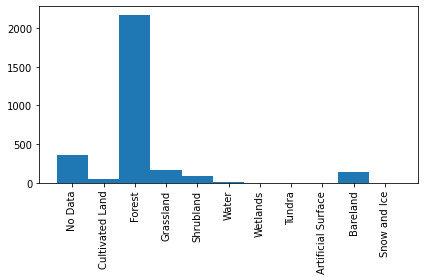

In [108]:
plt.hist(knn_pred, bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
true = y_val
pred = knn_pred

plt.figure(figsize=[15, 10])
plt.hist([true, pred], width = 0.25, histtype='bar', weights=[(np.zeros_like(true) + 1. / true.size), (np.zeros_like(pred) + 1. / pred.size)], align='mid')
# plt.hist(pred, color = 'y', width = 0.25, histtype='bar')
classes = ['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland']
plt.legend(['y True', 'y Prediction'])

plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

GridSearch optimal k parameter:

In [126]:
grid_search_params = {
    'n_neighbors': [3,5,10,15,20],
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_search_params,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

gs_results = gs.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.0min finished


In [139]:
# Best accuracy score
print('Best accuracy: ' + str(gs_results.best_score_))

# Best paramters
print('Best parameters: '+str(gs_results.best_params_))


Best accuracy: 0.7308554178323675
Best parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


In [140]:
# Apply best model and get predictions:
best_knn_predictions = gs_results.best_estimator_.predict(X_val)

# Print accuracy:
print(f"Accuracy: {accuracy_score(y_val, best_knn_predictions)*100}")

Accuracy: 74.86666666666667


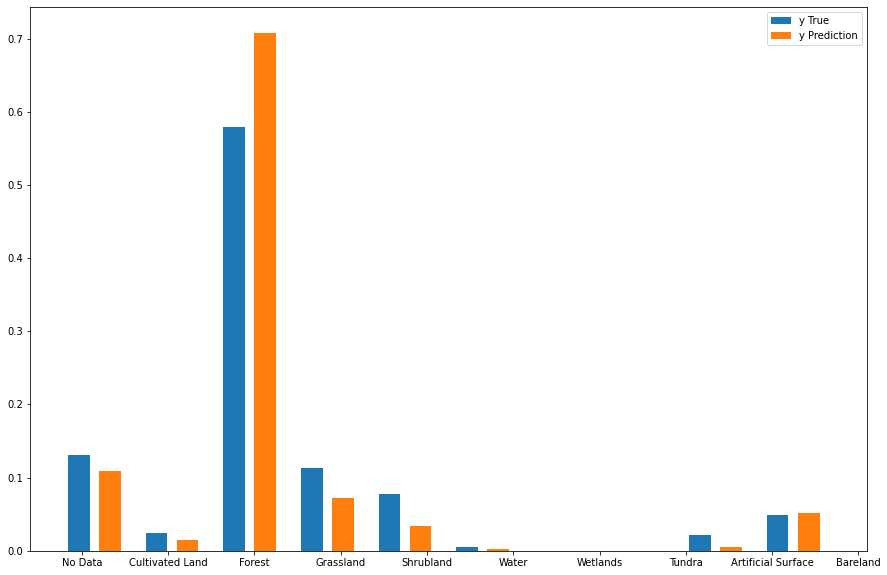

In [141]:
true = y_val
pred = best_knn_predictions

plt.figure(figsize=[15, 10])
plt.hist([true, pred], width = 0.25, histtype='bar', weights=[(np.zeros_like(true) + 1. / true.size), (np.zeros_like(pred) + 1. / pred.size)], align='mid')
# plt.hist(pred, color = 'y', width = 0.25, histtype='bar')
classes = ['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland']
plt.legend(['y True', 'y Prediction'])

plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

# Support Vector Machines


In [89]:
svm = SVC(C=1.0, kernel='linear', degree=6, cache_size=1024)

# Fit Data
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=1024, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=6, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [90]:
# Predict labels for test data
svm_pred = svm.predict(X_test)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_val, svm_pred)*100}")
print(classification_report(y_val, svm_pred))

Accuracy: 45.86666666666667
              precision    recall  f1-score   support

           0       0.11      0.07      0.09       392
           1       0.00      0.00      0.00        72
           2       0.58      0.75      0.65      1739
           3       0.11      0.09      0.10       338
           4       0.16      0.04      0.07       231
           5       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        65
           9       0.03      0.03      0.03       146

    accuracy                           0.46      3000
   macro avg       0.12      0.12      0.12      3000
weighted avg       0.38      0.46      0.41      3000



# Gradient Boosting Classifiers


## AdaBoost


In [95]:
adab = AdaBoostClassifier(n_estimators=250)

# Fit Data
adab.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=250, random_state=None)

In [96]:
# Predict labels for test data
adab_pred = adab.predict(X_test)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_val, adab_pred)*100}")
print(classification_report(y_val, adab_pred))

Accuracy: 28.46666666666667
              precision    recall  f1-score   support

           0       0.14      0.06      0.08       392
           1       0.03      0.17      0.05        72
           2       0.59      0.45      0.51      1739
           3       0.11      0.05      0.07       338
           4       0.08      0.01      0.02       231
           5       0.00      0.06      0.01        17
           8       0.02      0.05      0.03        65
           9       0.04      0.11      0.06       146

    accuracy                           0.28      3000
   macro avg       0.13      0.12      0.10      3000
weighted avg       0.38      0.28      0.32      3000



## Gradient Boosting Classifier


In [100]:
gbc = GradientBoostingClassifier()


# Fit Data
gbc.fit(X_train, y_train)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [102]:
# Predict labels for test data
gbc_pred = gbc.predict(X_test)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_val, gbc_pred)*100}")
print(classification_report(y_val, gbc_pred))

Accuracy: 41.266666666666666
              precision    recall  f1-score   support

           0       0.15      0.13      0.14       392
           1       0.02      0.01      0.01        72
           2       0.59      0.65      0.62      1739
           3       0.12      0.11      0.11       338
           4       0.07      0.04      0.05       231
           5       0.00      0.00      0.00        17
           8       0.02      0.02      0.02        65
           9       0.02      0.02      0.02       146

    accuracy                           0.41      3000
   macro avg       0.12      0.12      0.12      3000
weighted avg       0.38      0.41      0.40      3000



##lightGBM:


In [115]:
d_train = lgb.Dataset(X_train, label=y_train)

# Parameters
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=15
params['num_class']=11 #no.of unique values in the target class not inclusive of the end value

lgb_model = lgb.train(params, d_train, 100)


In [120]:
# prediction
lgb_predictions = lgb_model.predict(X_val)
lgb_pred = np.argmax(lgb_predictions, axis=1)

# Accuracy and Classification Report
print(f"Accuracy: {accuracy_score(y_val, lgb_pred)*100}")
print(classification_report(y_val, lgb_pred))

Accuracy: 78.43333333333334
              precision    recall  f1-score   support

           0       0.86      0.69      0.76       392
           1       0.62      0.28      0.38        72
           2       0.82      0.97      0.89      1739
           3       0.60      0.54      0.57       338
           4       0.52      0.24      0.33       231
           5       1.00      0.59      0.74        17
           8       0.73      0.37      0.49        65
           9       0.74      0.77      0.75       146

    accuracy                           0.78      3000
   macro avg       0.74      0.55      0.61      3000
weighted avg       0.77      0.78      0.76      3000



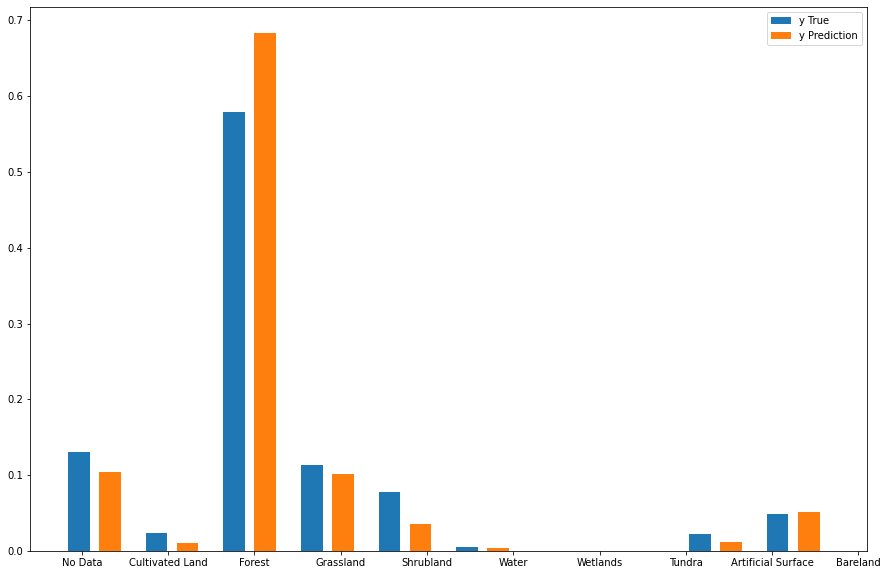

In [121]:
true = y_val
pred = lgb_pred

plt.figure(figsize=[15, 10])
plt.hist([true, pred], width = 0.25, histtype='bar', weights=[(np.zeros_like(true) + 1. / true.size), (np.zeros_like(pred) + 1. / pred.size)], align='mid')
# plt.hist(pred, color = 'y', width = 0.25, histtype='bar')
classes = ['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland']
plt.legend(['y True', 'y Prediction'])

plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()